In [ ]:
# Libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import random
import sklearn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Remove printing error
pd.options.mode.chained_assignment = None

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
from sklearn.metrics import roc_auc_score

from functions_folder.nn_MIMICDataset import MIMICDataset
from functions_folder.nn_model_simplex import Model_simplex
from functions_folder.nn_train import train
from functions_folder.nn_evaluate import evaluate

import shap

Data

In [2]:
mimic_data = pd.read_csv(r"mimic_data.csv")

In [8]:
model_data = mimic_data.drop(columns=['date', 'iv_flag', 'first_po_flag', 'iv_treatment_length'])

# Split into 'preprocessing dataset' and a 'train/vaid/test dataset'
stays = model_data['stay_id'].unique()
random.Random(0).shuffle(stays)
model_data2 = model_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.5 * len(stays))
preprocessing_stays = stays[:n]
hold_out_stays = stays[n:]
preprocessing_data = model_data2[model_data2['stay_id'].isin(preprocessing_stays)]
hold_out_data = model_data2[model_data2['stay_id'].isin(hold_out_stays)]

# Split into training, validation and testing
stays = preprocessing_data['stay_id'].unique()
random.Random(0).shuffle(stays)
preprocessing_data2 = preprocessing_data.set_index("stay_id").loc[stays].reset_index()
n = round(0.7 * len(stays))
n2 = round(0.85 * len(stays))
train_stays = stays[:n]
validation_stays = stays[n:n2]
test_stays = stays[n2:]
train_data = preprocessing_data2[preprocessing_data2['stay_id'].isin(train_stays)]
valid_data = preprocessing_data2[preprocessing_data2['stay_id'].isin(validation_stays)]
test_data = preprocessing_data2[preprocessing_data2['stay_id'].isin(test_stays)]

In [9]:
# Set the random seeds for deterministic results.
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [10]:
# Define batch size 
batch_size = 256

# Define dataloaders
train_dataset = MIMICDataset(train_data)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, collate_fn=train_dataset.collate_fn_padd)

valid_dataset = MIMICDataset(valid_data)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, collate_fn=valid_dataset.collate_fn_padd)

test_dataset = MIMICDataset(test_data)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=test_dataset.collate_fn_padd)

In [11]:
# Hyperparameters
INPUT_DIM = 960 # For fresh data
OUTPUT_DIM = 1
HID_DIM = 512 #128 #768
HID_DIM2 = 128 #128 #256
HID_DIM3 = 64
HID_DIM4 = 8
DROPOUT = 0.3

# Define model
model = Model_simplex(INPUT_DIM, OUTPUT_DIM, HID_DIM, HID_DIM2, HID_DIM3, HID_DIM4, DROPOUT).to(device)

# Initializing the weights of our model.
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

# Calculate the number of trainable parameters in the model.

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

# Define optimizer and learning_rate
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define loss
criterion = nn.BCEWithLogitsLoss()

# Define how long an epoch takes
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Model_simplex(
  (layers): Sequential(
    (0): BatchNorm1d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=960, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=512, out_features=128, bias=True)
    (8): ReLU()
    (9): ReLU()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.3, inplace=False)
    (13): Linear(in_features=128, out_features=64, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=64, out_features=64, bias=True)
    (17): ReLU()
    (18): Dropout(p=0.3, inplace=False)
    (19): Linear(in_features=64, out_features=8, bias=True)
    (20): ReLU()
    (21): Dropout(p=0.3, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=8, out_featu

The model has 851,729 trainable parameters


In [12]:
# Define epochs and clip
N_EPOCHS = 50
CLIP = 1

# Run
best_valid_loss = float('inf')
best_valid_auroc = 0

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_accuracy, train_auroc, train_predictions, train_labels = train(model, train_dataloader, optimizer, criterion, CLIP)
    valid_loss, valid_accuracy, valid_auroc, valid_predictions, valid_labels = evaluate(model, valid_dataloader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print('BEST VALID LOSS')

    if valid_auroc > best_valid_auroc:
        best_valid_auroc = valid_auroc
        print('UPDATED BEST MODEL')
        torch.save(model.state_dict(), 'switch_model_all.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss} | Train PPL: {math.exp(train_loss)}')
    print(f'\t Val. Loss: {valid_loss} |  Val. PPL: {math.exp(valid_loss)}')
    if valid_loss > train_loss:
        print('Val. Loss >  Train Loss, overfitting')
    elif train_loss > valid_loss:
        print('Train. Loss >  Val Loss, underfitting')
    else:
        print('Train. Loss =  Val Loss')

    print('Train accuracy result:', train_accuracy)
    print('Train AUROC result:', train_auroc)
    print(np.unique(train_predictions.round(), return_counts=True))
    print(np.unique(train_labels.round(), return_counts=True))
    print('Validation accuracy result:', valid_accuracy)
    print('Validation AUROC result:', valid_auroc)
    print(np.unique(valid_predictions.round(), return_counts=True))
    print(np.unique(valid_labels.round(), return_counts=True))

100%|██████████| 9/9 [00:02<00:00,  4.07it/s]


BEST VALID LOSS
UPDATED BEST MODEL
Epoch: 01 | Time: 0m 13s
	Train Loss: 0.5445734828710556 | Train PPL: 1.7238729642060027
	 Val. Loss: 0.3958524465560913 |  Val. PPL: 1.4856500885907786
Train. Loss >  Val Loss, underfitting
Train accuracy result: 0.8302369016022806
Train AUROC result: 0.5
(array([0.], dtype=float32), array([10173]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8408352668213457
Validation AUROC result: 0.5
(array([0.], dtype=float32), array([2155]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


BEST VALID LOSS
Epoch: 02 | Time: 0m 12s
	Train Loss: 0.37347000688314436 | Train PPL: 1.4527669898799465
	 Val. Loss: 0.32709912459055585 |  Val. PPL: 1.3869389501222718
Train. Loss >  Val Loss, underfitting
Train accuracy result: 0.8302369016022806
Train AUROC result: 0.5
(array([0.], dtype=float32), array([10173]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8408352668213457
Validation AUROC result: 0.5
(array([0.], dtype=float32), array([2155]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.10it/s]


BEST VALID LOSS
Epoch: 03 | Time: 0m 12s
	Train Loss: 0.3354733735322952 | Train PPL: 1.398602289852264
	 Val. Loss: 0.3124789463149177 |  Val. PPL: 1.3668091645011529
Train. Loss >  Val Loss, underfitting
Train accuracy result: 0.8302369016022806
Train AUROC result: 0.5
(array([0.], dtype=float32), array([10173]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8408352668213457
Validation AUROC result: 0.5
(array([0.], dtype=float32), array([2155]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


BEST VALID LOSS
Epoch: 04 | Time: 0m 12s
	Train Loss: 0.31946758553385735 | Train PPL: 1.3763947567417365
	 Val. Loss: 0.30638036959701115 |  Val. PPL: 1.3584989399801788
Train. Loss >  Val Loss, underfitting
Train accuracy result: 0.8302369016022806
Train AUROC result: 0.5
(array([0.], dtype=float32), array([10173]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8408352668213457
Validation AUROC result: 0.5
(array([0.], dtype=float32), array([2155]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


BEST VALID LOSS
UPDATED BEST MODEL
Epoch: 05 | Time: 0m 12s
	Train Loss: 0.3133062206208706 | Train PPL: 1.3679403584434133
	 Val. Loss: 0.30606797834237415 |  Val. PPL: 1.3580746230717917
Train. Loss >  Val Loss, underfitting
Train accuracy result: 0.8375110586847537
Train AUROC result: 0.542383535114802
(array([0., 1.], dtype=float32), array([9917,  256]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.859860788863109
Validation AUROC result: 0.6046746986400994
(array([0., 1.], dtype=float32), array([2038,  117]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


BEST VALID LOSS
Epoch: 06 | Time: 0m 12s
	Train Loss: 0.2957574646919966 | Train PPL: 1.344144114888404
	 Val. Loss: 0.3008662346336577 |  Val. PPL: 1.351028608613612
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.8684753759952816
Train AUROC result: 0.7091270321718232
(array([0., 1.], dtype=float32), array([8946, 1227]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8603248259860788
Validation AUROC result: 0.6002234857992393
(array([0., 1.], dtype=float32), array([2047,  108]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Epoch: 07 | Time: 0m 12s
	Train Loss: 0.2837662797421217 | Train PPL: 1.3281224853457487
	 Val. Loss: 0.3026479201184379 |  Val. PPL: 1.3534378623039378
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.8773223237982896
Train AUROC result: 0.721134271596481
(array([0., 1.], dtype=float32), array([8978, 1195]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8584686774941995
Validation AUROC result: 0.5932107942514754
(array([0., 1.], dtype=float32), array([2053,  102]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.17it/s]


UPDATED BEST MODEL
Epoch: 08 | Time: 0m 12s
	Train Loss: 0.27413673549890516 | Train PPL: 1.3153946510864567
	 Val. Loss: 0.3021819591522217 |  Val. PPL: 1.3528073599960453
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.8852845768209967
Train AUROC result: 0.738597028624645
(array([0., 1.], dtype=float32), array([8949, 1224]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8705336426914153
Validation AUROC result: 0.6441113342214841
(array([0., 1.], dtype=float32), array([2005,  150]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.07it/s]


UPDATED BEST MODEL
Epoch: 09 | Time: 0m 12s
	Train Loss: 0.2600815251469612 | Train PPL: 1.297035823391728
	 Val. Loss: 0.3105565839343601 |  Val. PPL: 1.3641841858703783
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.8936400275238376
Train AUROC result: 0.758599781904071
(array([0., 1.], dtype=float32), array([8904, 1269]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8696055684454757
Validation AUROC result: 0.6494683966301752
(array([0., 1.], dtype=float32), array([1993,  162]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.10it/s]


Epoch: 10 | Time: 0m 12s
	Train Loss: 0.2401651494204998 | Train PPL: 1.2714591137190807
	 Val. Loss: 0.31417405274179244 |  Val. PPL: 1.3691280162952535
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9045512631475474
Train AUROC result: 0.7753050100224582
(array([0., 1.], dtype=float32), array([8927, 1246]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8677494199535963
Validation AUROC result: 0.6211835254442363
(array([0., 1.], dtype=float32), array([2035,  120]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


UPDATED BEST MODEL
Epoch: 11 | Time: 0m 12s
	Train Loss: 0.2220550611615181 | Train PPL: 1.2486401275472883
	 Val. Loss: 0.3354810078938802 |  Val. PPL: 1.3986129673286163
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9137914086306891
Train AUROC result: 0.7969921587753721
(array([0., 1.], dtype=float32), array([8881, 1292]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8784222737819025
Validation AUROC result: 0.701982732544295
(array([0., 1.], dtype=float32), array([1932,  223]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch: 12 | Time: 0m 12s
	Train Loss: 0.201904309540987 | Train PPL: 1.2237309031367036
	 Val. Loss: 0.36028892132971024 |  Val. PPL: 1.4337435938304395
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9188046790523936
Train AUROC result: 0.8080725316363186
(array([0., 1.], dtype=float32), array([8862, 1311]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8709976798143851
Validation AUROC result: 0.6609323010187991
(array([0., 1.], dtype=float32), array([1978,  177]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch: 13 | Time: 0m 12s
	Train Loss: 0.1762442324310541 | Train PPL: 1.192729326263666
	 Val. Loss: 0.38535146249665153 |  Val. PPL: 1.4701309265380136
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9337461908974737
Train AUROC result: 0.8470124450149668
(array([0., 1.], dtype=float32), array([8754, 1419]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8649651972157772
Validation AUROC result: 0.6396182881856621
(array([0., 1.], dtype=float32), array([1995,  160]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Epoch: 14 | Time: 0m 12s
	Train Loss: 0.15081932563334705 | Train PPL: 1.1627865533780404
	 Val. Loss: 0.44439049230681527 |  Val. PPL: 1.5595393548550491
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9423965398604148
Train AUROC result: 0.8678837564877919
(array([0., 1.], dtype=float32), array([8706, 1467]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8705336426914153
Validation AUROC result: 0.640565970948455
(array([0., 1.], dtype=float32), array([2011,  144]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.14it/s]


Epoch: 15 | Time: 0m 12s
	Train Loss: 0.13037290889769793 | Train PPL: 1.1392531417548912
	 Val. Loss: 0.5269968211650848 |  Val. PPL: 1.6938377648094334
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9486877027425539
Train AUROC result: 0.8822672419667793
(array([0., 1.], dtype=float32), array([8678, 1495]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8700696055684455
Validation AUROC result: 0.6450171837893152
(array([0., 1.], dtype=float32), array([2002,  153]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


UPDATED BEST MODEL
Epoch: 16 | Time: 0m 12s
	Train Loss: 0.1268512697890401 | Train PPL: 1.1352481595263775
	 Val. Loss: 0.4005091256565518 |  Val. PPL: 1.4925844172498788
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9548805662046594
Train AUROC result: 0.8945186498345497
(array([0., 1.], dtype=float32), array([8667, 1506]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8658932714617169
Validation AUROC result: 0.7536217893022866
(array([0., 1.], dtype=float32), array([1805,  350]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.21it/s]


Epoch: 17 | Time: 0m 12s
	Train Loss: 0.11481694262474776 | Train PPL: 1.1216680891609352
	 Val. Loss: 0.5211798681153191 |  Val. PPL: 1.6840133917183375
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.958517644745896
Train AUROC result: 0.9036186291163961
(array([0., 1.], dtype=float32), array([8644, 1529]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8645011600928074
Validation AUROC result: 0.706704252183371
(array([0., 1.], dtype=float32), array([1880,  275]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.17it/s]


Epoch: 18 | Time: 0m 12s
	Train Loss: 0.07066222904250026 | Train PPL: 1.0732186625448696
	 Val. Loss: 0.5968801048066881 |  Val. PPL: 1.8164428395090924
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9745404502113437
Train AUROC result: 0.9390639823472009
(array([0., 1.], dtype=float32), array([8583, 1590]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8556844547563806
Validation AUROC result: 0.7357332715489223
(array([0., 1.], dtype=float32), array([1803,  352]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.33it/s]


UPDATED BEST MODEL
Epoch: 19 | Time: 0m 12s
	Train Loss: 0.0724044436123222 | Train PPL: 1.0750900694581969
	 Val. Loss: 0.5652838829490874 |  Val. PPL: 1.7599473308503826
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9722795635505751
Train AUROC result: 0.9383933503914167
(array([0., 1.], dtype=float32), array([8554, 1619]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8487238979118329
Validation AUROC result: 0.7682296191892083
(array([0., 1.], dtype=float32), array([1726,  429]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.33it/s]


UPDATED BEST MODEL
Epoch: 20 | Time: 0m 12s
	Train Loss: 0.06927082454785705 | Train PPL: 1.0717264196715395
	 Val. Loss: 0.7421329120794932 |  Val. PPL: 2.1004107315967793
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9745404502113437
Train AUROC result: 0.9434400581040683
(array([0., 1.], dtype=float32), array([8545, 1628]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8320185614849188
Validation AUROC result: 0.8091127179348561
(array([0., 1.], dtype=float32), array([1604,  551]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Epoch: 21 | Time: 0m 13s
	Train Loss: 0.07818549936637283 | Train PPL: 1.0813232248401115
	 Val. Loss: 0.7607039246294234 |  Val. PPL: 2.139781935685765
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9714931681903077
Train AUROC result: 0.9402229511892097
(array([0., 1.], dtype=float32), array([8526, 1647]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8069605568445476
Validation AUROC result: 0.8013027822292588
(array([0., 1.], dtype=float32), array([1538,  617]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.29it/s]


Epoch: 22 | Time: 0m 12s
	Train Loss: 0.08366850186139345 | Train PPL: 1.087268406608753
	 Val. Loss: 0.567019436094496 |  Val. PPL: 1.7630044651183132
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9690356826894722
Train AUROC result: 0.9410461584279214
(array([0., 1.], dtype=float32), array([8481, 1692]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8213457076566125
Validation AUROC result: 0.7968572007800282
(array([0., 1.], dtype=float32), array([1591,  564]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Epoch: 23 | Time: 0m 12s
	Train Loss: 0.09483608044683933 | Train PPL: 1.099478614310842
	 Val. Loss: 0.6322577529483371 |  Val. PPL: 1.8818545492005394
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9621547232871326
Train AUROC result: 0.9318351498624525
(array([0., 1.], dtype=float32), array([8455, 1718]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8719257540603248
Validation AUROC result: 0.7040285366748402
(array([0., 1.], dtype=float32), array([1908,  247]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch: 24 | Time: 0m 12s
	Train Loss: 0.053178275609388946 | Train PPL: 1.0546176409639363
	 Val. Loss: 0.7704706655608283 |  Val. PPL: 2.1607830206398115
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9828959009141847
Train AUROC result: 0.9634428113834943
(array([0., 1.], dtype=float32), array([8500, 1673]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8561484918793504
Validation AUROC result: 0.7289184831927095
(array([0., 1.], dtype=float32), array([1816,  339]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch: 25 | Time: 0m 12s
	Train Loss: 0.032066197134554386 | Train PPL: 1.0325858572676738
	 Val. Loss: 0.9145276347796122 |  Val. PPL: 2.4955961406202687
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9886955666961565
Train AUROC result: 0.9731542230000023
(array([0., 1.], dtype=float32), array([8505, 1668]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8440835266821346
Validation AUROC result: 0.7548341474716661
(array([0., 1.], dtype=float32), array([1734,  421]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.16it/s]


Epoch: 26 | Time: 0m 12s
	Train Loss: 0.03137113088741898 | Train PPL: 1.0318683910631739
	 Val. Loss: 0.9085709883107079 |  Val. PPL: 2.4807749428225327
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9879091713358891
Train AUROC result: 0.9708380678176052
(array([0., 1.], dtype=float32), array([8513, 1660]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8487238979118329
Validation AUROC result: 0.743412076278004
(array([0., 1.], dtype=float32), array([1768,  387]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.18it/s]


Epoch: 27 | Time: 0m 12s
	Train Loss: 0.026509793917648496 | Train PPL: 1.0268643042368655
	 Val. Loss: 0.8931901388698154 |  Val. PPL: 2.442910457370691
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9887938661161899
Train AUROC result: 0.9720618237377386
(array([0., 1.], dtype=float32), array([8516, 1657]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8552204176334107
Validation AUROC result: 0.7531841497242227
(array([0., 1.], dtype=float32), array([1772,  383]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.10it/s]


Epoch: 28 | Time: 0m 12s
	Train Loss: 0.02029294865205884 | Train PPL: 1.0205002504147052
	 Val. Loss: 1.3130475812488132 |  Val. PPL: 3.717485806227856
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9913496510370589
Train AUROC result: 0.977977089643789
(array([0., 1.], dtype=float32), array([8504, 1669]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8468677494199536
Validation AUROC result: 0.7458536867916514
(array([0., 1.], dtype=float32), array([1758,  397]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Epoch: 29 | Time: 0m 12s
	Train Loss: 0.020541112625505776 | Train PPL: 1.0207535332382878
	 Val. Loss: 1.4348478780852423 |  Val. PPL: 4.199006199337575
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9902683574166913
Train AUROC result: 0.9766349344814107
(array([0., 1.], dtype=float32), array([8499, 1674]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8324825986078886
Validation AUROC result: 0.7963889907902613
(array([0., 1.], dtype=float32), array([1627,  528]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.18it/s]


Epoch: 30 | Time: 0m 12s
	Train Loss: 0.026548745523905383 | Train PPL: 1.0269043030299267
	 Val. Loss: 1.03383027182685 |  Val. PPL: 2.8118152517033934
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.991841148137226
Train AUROC result: 0.9819582041762368
(array([0., 1.], dtype=float32), array([8477, 1696]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8468677494199536
Validation AUROC result: 0.7777619562489139
(array([0., 1.], dtype=float32), array([1704,  451]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Epoch: 31 | Time: 0m 12s
	Train Loss: 0.02311135223135352 | Train PPL: 1.0233804889038052
	 Val. Loss: 1.2893587483300104 |  Val. PPL: 3.6304577720552347
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9912513516170255
Train AUROC result: 0.9779178900226667
(array([0., 1.], dtype=float32), array([8503, 1670]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8283062645011601
Validation AUROC result: 0.7820876695048881
(array([0., 1.], dtype=float32), array([1638,  517]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Epoch: 32 | Time: 0m 12s
	Train Loss: 0.01952013446716592 | Train PPL: 1.019711898009695
	 Val. Loss: 1.1410939296086628 |  Val. PPL: 3.130190701236344
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9903666568367246
Train AUROC result: 0.9764638143258558
(array([0., 1.], dtype=float32), array([8502, 1671]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8468677494199536
Validation AUROC result: 0.7765801684912376
(array([0., 1.], dtype=float32), array([1706,  449]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch: 33 | Time: 0m 12s
	Train Loss: 0.017280648287851363 | Train PPL: 1.0174308224791382
	 Val. Loss: 1.2638904319869146 |  Val. PPL: 3.5391636139588374
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9928241423375602
Train AUROC result: 0.982550200387461
(array([0., 1.], dtype=float32), array([8487, 1686]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8445475638051044
Validation AUROC result: 0.7763822652996866
(array([0., 1.], dtype=float32), array([1699,  456]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch: 34 | Time: 0m 12s
	Train Loss: 0.022625928797060622 | Train PPL: 1.0228838365853827
	 Val. Loss: 1.038163787788815 |  Val. PPL: 2.8240267382042625
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9912513516170255
Train AUROC result: 0.9786088493526984
(array([0., 1.], dtype=float32), array([8497, 1676]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8334106728538283
Validation AUROC result: 0.7626690221973368
(array([0., 1.], dtype=float32), array([1687,  468]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch: 35 | Time: 0m 12s
	Train Loss: 0.018208598834462464 | Train PPL: 1.018375386153406
	 Val. Loss: 1.1257813572883606 |  Val. PPL: 3.0826245393133886
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9909564533569252
Train AUROC result: 0.9777402911592994
(array([0., 1.], dtype=float32), array([8500, 1673]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.851508120649652
Validation AUROC result: 0.7651580972975757
(array([0., 1.], dtype=float32), array([1740,  415]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.36it/s]


Epoch: 36 | Time: 0m 12s
	Train Loss: 0.024009483598638325 | Train PPL: 1.0243000318949473
	 Val. Loss: 1.0395355489518907 |  Val. PPL: 2.8279032866486356
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9897768603165241
Train AUROC result: 0.9740357386090263
(array([0., 1.], dtype=float32), array([8514, 1659]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8361948955916473
Validation AUROC result: 0.7725971656401444
(array([0., 1.], dtype=float32), array([1679,  476]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.36it/s]


Epoch: 37 | Time: 0m 11s
	Train Loss: 0.01878467542119324 | Train PPL: 1.0189622173835087
	 Val. Loss: 1.1040461593204074 |  Val. PPL: 3.016345982714205
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.991841148137226
Train AUROC result: 0.97919436685611
(array([0., 1.], dtype=float32), array([8501, 1672]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8529002320185615
Validation AUROC result: 0.7648041241094358
(array([0., 1.], dtype=float32), array([1745,  410]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch: 38 | Time: 0m 12s
	Train Loss: 0.020327772066229953 | Train PPL: 1.0205357883363595
	 Val. Loss: 1.2328297694524128 |  Val. PPL: 3.430924537961475
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9928241423375602
Train AUROC result: 0.9820895608341065
(array([0., 1.], dtype=float32), array([8491, 1682]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8580046403712297
Validation AUROC result: 0.7619305054093539
(array([0., 1.], dtype=float32), array([1766,  389]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


Epoch: 39 | Time: 0m 12s
	Train Loss: 0.02585130137158558 | Train PPL: 1.0261883443284132
	 Val. Loss: 0.967122475306193 |  Val. PPL: 2.630364619849327
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9908581539368918
Train AUROC result: 0.975838533324759
(array([0., 1.], dtype=float32), array([8515, 1658]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8575406032482599
Validation AUROC result: 0.7581092039464792
(array([0., 1.], dtype=float32), array([1771,  384]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Epoch: 40 | Time: 0m 12s
	Train Loss: 0.019813959230668844 | Train PPL: 1.0200115586386698
	 Val. Loss: 1.1837063034375508 |  Val. PPL: 3.266458280982076
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9904649562567581
Train AUROC result: 0.9746804557335604
(array([0., 1.], dtype=float32), array([8519, 1654]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8556844547563806
Validation AUROC result: 0.7440057858526571
(array([0., 1.], dtype=float32), array([1789,  366]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.32it/s]


Epoch: 41 | Time: 0m 12s
	Train Loss: 0.021991676895413547 | Train PPL: 1.0222352762639146
	 Val. Loss: 0.9272465970781114 |  Val. PPL: 2.527540251176612
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9914479504570923
Train AUROC result: 0.9773453299348798
(array([0., 1.], dtype=float32), array([8511, 1662]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8589327146171694
Validation AUROC result: 0.7423919899085462
(array([0., 1.], dtype=float32), array([1802,  353]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.37it/s]


Epoch: 42 | Time: 0m 11s
	Train Loss: 0.015930544771254062 | Train PPL: 1.016058112406675
	 Val. Loss: 1.3366579744550917 |  Val. PPL: 3.8063014683806276
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9912513516170255
Train AUROC result: 0.9756146922558944
(array([0., 1.], dtype=float32), array([8523, 1650]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8491879350348028
Validation AUROC result: 0.7354155001641149
(array([0., 1.], dtype=float32), array([1783,  372]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Epoch: 43 | Time: 0m 12s
	Train Loss: 0.011990216418053024 | Train PPL: 1.0120623872223402
	 Val. Loss: 1.6109894514083862 |  Val. PPL: 5.007763716168091
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9936105376978276
Train AUROC result: 0.9834844369097948
(array([0., 1.], dtype=float32), array([8491, 1682]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8603248259860788
Validation AUROC result: 0.7337655024166715
(array([0., 1.], dtype=float32), array([1821,  334]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Epoch: 44 | Time: 0m 12s
	Train Loss: 0.013545626282575541 | Train PPL: 1.0136377839191064
	 Val. Loss: 1.4884244865841336 |  Val. PPL: 4.430110319568618
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9929224417575936
Train AUROC result: 0.9816881209018745
(array([0., 1.], dtype=float32), array([8496, 1677]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8473317865429234
Validation AUROC result: 0.7532203515275552
(array([0., 1.], dtype=float32), array([1747,  408]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Epoch: 45 | Time: 0m 12s
	Train Loss: 0.022139836370479317 | Train PPL: 1.0223867413260546
	 Val. Loss: 0.9019235173861185 |  Val. PPL: 2.4643387535893635
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.991153052196992
Train AUROC result: 0.9776283706248668
(array([0., 1.], dtype=float32), array([8504, 1669]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8547563805104408
Validation AUROC result: 0.7351813951692313
(array([0., 1.], dtype=float32), array([1801,  354]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]


Epoch: 46 | Time: 0m 12s
	Train Loss: 0.014409645192790777 | Train PPL: 1.0145139645963501
	 Val. Loss: 1.2128683394855924 |  Val. PPL: 3.3631173933733445
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9923326452373931
Train AUROC result: 0.9787994056316905
(array([0., 1.], dtype=float32), array([8512, 1661]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8626450116009281
Validation AUROC result: 0.7315998300928697
(array([0., 1.], dtype=float32), array([1832,  323]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch: 47 | Time: 0m 12s
	Train Loss: 0.010758678650017828 | Train PPL: 1.0108167613439603
	 Val. Loss: 1.5432693693372939 |  Val. PPL: 4.679865495961089
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.994396933058095
Train AUROC result: 0.9855702723155149
(array([0., 1.], dtype=float32), array([8485, 1688]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8593967517401392
Validation AUROC result: 0.7568493811905084
(array([0., 1.], dtype=float32), array([1779,  376]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Epoch: 48 | Time: 0m 12s
	Train Loss: 0.01793979328358546 | Train PPL: 1.0181016779855168
	 Val. Loss: 1.370404130882687 |  Val. PPL: 3.9369414136282335
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9917428487171925
Train AUROC result: 0.9798261265650192
(array([0., 1.], dtype=float32), array([8494, 1679]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8464037122969837
Validation AUROC result: 0.7514866873901879
(array([0., 1.], dtype=float32), array([1747,  408]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.36it/s]


Epoch: 49 | Time: 0m 11s
	Train Loss: 0.013197490281891077 | Train PPL: 1.0132849615335207
	 Val. Loss: 1.3357078631718953 |  Val. PPL: 3.802686775860265
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9927258429175267
Train AUROC result: 0.9818000414363068
(array([0., 1.], dtype=float32), array([8492, 1681]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.854292343387471
Validation AUROC result: 0.7396326080100915
(array([0., 1.], dtype=float32), array([1792,  363]))
(array([0., 1.], dtype=float32), array([1812,  343]))


100%|██████████| 9/9 [00:02<00:00,  4.23it/s]

Epoch: 50 | Time: 0m 12s
	Train Loss: 0.013264013142907061 | Train PPL: 1.0133523703902765
	 Val. Loss: 1.473354246881273 |  Val. PPL: 4.363848043410861
Val. Loss >  Train Loss, overfitting
Train accuracy result: 0.9930207411776271
Train AUROC result: 0.981977640299674
(array([0., 1.], dtype=float32), array([8495, 1678]))
(array([0., 1.], dtype=float32), array([8446, 1727]))
Validation accuracy result: 0.8519721577726218
Validation AUROC result: 0.7488890068799515
(array([0., 1.], dtype=float32), array([1769,  386]))
(array([0., 1.], dtype=float32), array([1812,  343]))


In [13]:
# -----------------------------
# Evaluate best model on test set
# -----------------------------

model.load_state_dict(torch.load('switch_model_all.pt'))

test_loss, test_accuracy, test_auroc, test_predictions, test_labels = evaluate(model, test_dataloader, criterion)

print(f'\n| Test Loss: {test_loss} | Test PPL: {math.exp(test_loss)} |')
print('Test accuracy result:', test_accuracy)
print('Test AUROC result:', test_auroc)
#torch.set_printoptions(edgeitems=10)
print(np.unique(test_predictions.round(), return_counts=True))
print(np.unique(test_labels.round(), return_counts=True))
print('test_predictions', test_predictions)
print('test_labels', test_labels)

<All keys matched successfully>

100%|██████████| 9/9 [00:02<00:00,  4.12it/s]


| Test Loss: 0.9326660301950243 | Test PPL: 2.5412752709118394 |
Test accuracy result: 0.8038321167883211
Test AUROC result: 0.7582185025068763
(array([0., 1.], dtype=float32), array([1641,  551]))
(array([0., 1.], dtype=float32), array([1881,  311]))
test_predictions [0.0000000e+00 9.2310198e-28 1.3590901e-01 ... 6.4171553e-01 3.8969242e-15
 1.9546336e-14]
test_labels [0. 0. 0. ... 1. 0. 0.]


shap

Model_simplex(
  (layers): Sequential(
    (0): BatchNorm1d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=960, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=512, out_features=128, bias=True)
    (8): ReLU()
    (9): ReLU()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.3, inplace=False)
    (13): Linear(in_features=128, out_features=64, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=64, out_features=64, bias=True)
    (17): ReLU()
    (18): Dropout(p=0.3, inplace=False)
    (19): Linear(in_features=64, out_features=8, bias=True)
    (20): ReLU()
    (21): Dropout(p=0.3, inplace=False)
  )
  (layers2): Sequential(
    (0): Linear(in_features=8, out_featu

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


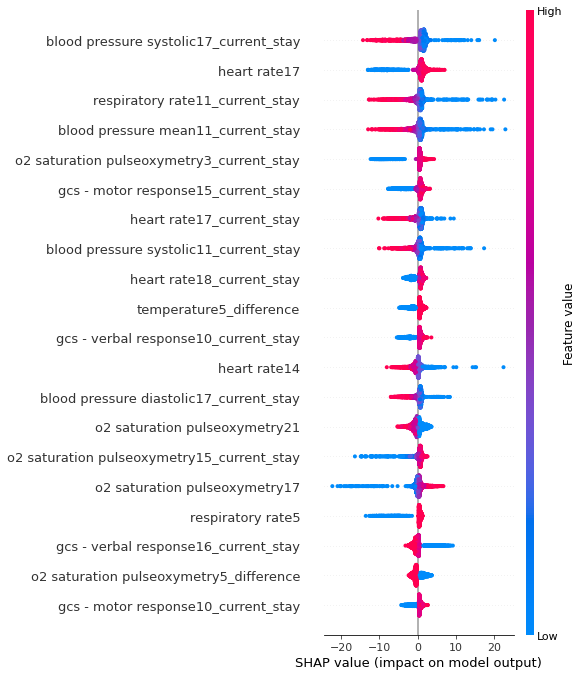

In [14]:
torch.set_grad_enabled(True)

# Get features
train_features = train_data.drop(columns=['stay_id', 'po_flag'])
test_features = test_data.drop(columns=['stay_id', 'po_flag'])

# Load and move model to cpu
#model.load_state_dict(torch.load('fresh_switch_model_all.pt'))
model.to('cpu')
# Define DeepExplainer (train data)
e = shap.DeepExplainer(model, torch.from_numpy(train_features.to_numpy(dtype=np.float32)))
# Get the shap values from my test data (this explainer likes tensors)
shap_values = e.shap_values(torch.from_numpy(test_features.to_numpy(dtype=np.float32)))
# Define feature_names
feature_names = test_features.columns
# Plot
shap.summary_plot(shap_values, test_features.to_numpy(dtype=np.float32), feature_names)

In [15]:
# get features with the highest shap values
rf_resultX = pd.DataFrame(shap_values, columns=feature_names)

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance.head()

,col_name,feature_importance_vals
137,blood pressure systolic17_current_stay,2.267795
305,heart rate17,2.052705
419,respiratory rate11_current_stay,1.657936
83,blood pressure mean11_current_stay,1.617050
363,o2 saturation pulseoxymetry3_current_stay,1.383182


In [16]:
shap_importance = shap_importance.reset_index(drop=True)

In [17]:
shap_importance

,col_name,feature_importance_vals
0,blood pressure systolic17_current_stay,2.267795
1,heart rate17,2.052705
2,respiratory rate11_current_stay,1.657936
3,blood pressure mean11_current_stay,1.617050
4,o2 saturation pulseoxymetry3_current_stay,1.383182
...,...,...
955,heart rate18,0.000000
956,heart rate19,0.000000
957,heart rate19_difference,0.000000
958,temperature18_difference,0.000000


In [18]:
# Save
#shap_importance.to_csv('all_shap_importance.csv', index=False)